<a href="https://colab.research.google.com/github/bybbaa/MN/blob/main/LR_10_Natsyk_Yuliia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from tensorflow.keras.layers import (Input, Rescaling, RandomFlip, RandomRotation, RandomContrast,
                                     Conv2D, BatchNormalization, MaxPool2D,
                                     GlobalAveragePooling2D, Dense, Dropout)

from tensorflow.keras.regularizers import l2


ВАРІАНТ 1

In [ ]:
# Шлях до директорії з тренувальними зображеннями
train_images_dir = '/kaggle/input/gtsrb-german-traffic-sign/Train'

# Списки для зображень і міток
images = []
labels = []

# Проходимо по кожній папці (класу)
for class_folder in os.listdir(train_images_dir):
    class_folder_path = os.path.join(train_images_dir, class_folder)

    # Перевіряємо, чи є це папка, і якщо так, то зберігаємо зображення
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            # Створення шляху до зображення
            img_path = os.path.join(class_folder_path, image_file)
            # Завантаження зображення
            img = image.load_img(img_path, target_size=(32, 32))  # зміна розміру на 32x32
            img_array = image.img_to_array(img)

            # Додаємо зображення в список
            images.append(img_array)
            # Додаємо мітку класу (число)
            labels.append(int(class_folder))

# Перетворюємо списки у NumPy масиви
images = np.array(images)
labels = np.array(labels)

# Перевірка форми даних
print(f"Форма зображень: {images.shape}")
print(f"Мітки класів: {labels.shape}")

Форма зображень: (39209, 32, 32, 3)
Мітки класів: (39209,)


In [ ]:
# Поділ на тренувальні та тестові дані
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Розмір тренувальних даних: {X_train.shape}")
print(f"Розмір тестових даних: {X_test.shape}")

Розмір тренувальних даних: (31367, 32, 32, 3)
Розмір тестових даних: (7842, 32, 32, 3)


In [ ]:
# Перетворення міток на one-hot encoding
y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

print(f"Форма y_train після перетворення: {y_train.shape}")  # Очікується (кількість_зразків, 43)
print(f"Форма y_test після перетворення: {y_test.shape}")    # Очікується (кількість_зразків, 43)

Форма y_train після перетворення: (31367, 43)
Форма y_test після перетворення: (7842, 43)


In [ ]:
height, width, channels = 32, 32, 3
NUM_CATEGORIES = 43  # Кількість класів для GTSRB

# Створення моделі
model = Sequential([
    Input(shape=(height, width, channels)),

    # Нормалізація + аугментації
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomContrast(0.1),

    # Блок 1
    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(32, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    # Блок 2
    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    # Блок 3
    Conv2D(128, (3,3), padding="same", activation="relu", kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPool2D(),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(NUM_CATEGORIES, activation="softmax")
])



In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

LOSS = CategoricalCrossentropy()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=LOSS,
    metrics=[
        "accuracy",
        TopKCategoricalAccuracy(k=3, name="top3")
    ]
)

cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # щоб працював val_accuracy і val_loss
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=cb,
    verbose=1
)

Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.1282 - loss: 3.4658 - top3: 0.2764 - val_accuracy: 0.4373 - val_loss: 1.9991 - val_top3: 0.6909 - learning_rate: 3.0000e-04
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.4044 - loss: 1.9834 - top3: 0.6549 - val_accuracy: 0.6599 - val_loss: 1.2026 - val_top3: 0.8689 - learning_rate: 3.0000e-04
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6216 - loss: 1.1963 - top3: 0.8529 - val_accuracy: 0.8430 - val_loss: 0.5634 - val_top3: 0.9756 - learning_rate: 3.0000e-04
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7656 - loss: 0.7368 - top3: 0.9407 - val_accuracy: 0.9133 - val_loss: 0.3149 - val_top3: 0.9894 - learning_rate: 3.0000e-04
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8425 - loss: 0.5009 - top3: 0.9722 - val_accuracy: 0.9492 - val_loss: 0.1993 - val_top3: 0.9966 - learning_rate: 3.0000e-04
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
training_accuracy = history.history["accuracy"]
training_loss = history.history["loss"]
validation_accuracy = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

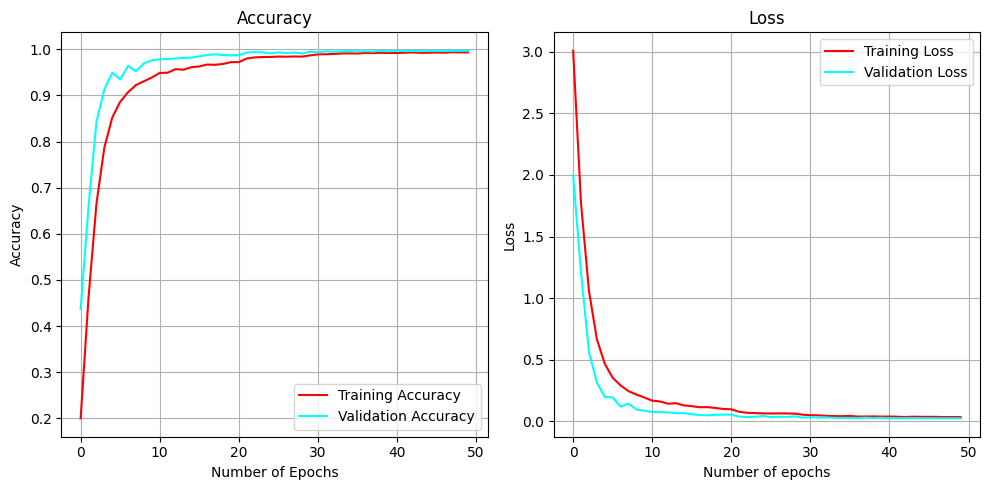

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, color = "red", label = "Training Accuracy")
plt.plot(validation_accuracy, color = "cyan", label = "Validation Accuracy")
plt.legend()
plt.grid(True)
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(training_loss, color = "red", label = "Training Loss")
plt.plot(validation_loss, color = "cyan", label = "Validation Loss")
plt.grid(True)
plt.legend()
plt.title("Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


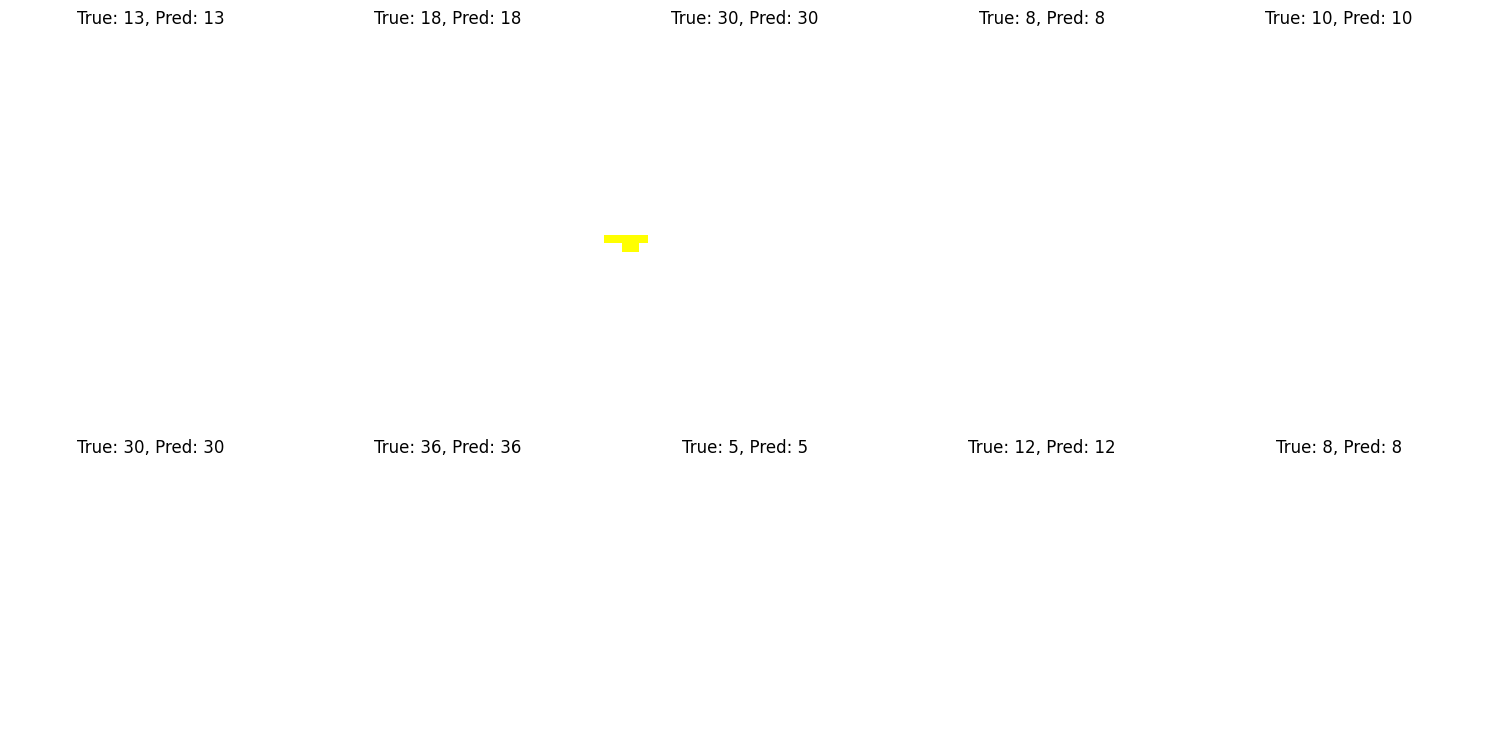

In [ ]:
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Прогнозування класів для тестових даних
y_pred = model.predict(X_test)

# Виведення зображень та їхніх прогнозованих і справжніх класів
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])  # Показуємо зображення
    plt.axis('off')

    true_class = np.argmax(y_test[idx])  # Справжній клас
    predicted_class = np.argmax(y_pred[idx])  # Прогнозований клас

    plt.title(f"True: {true_class}, Pred: {predicted_class}")

plt.tight_layout()
plt.show()